### Imports

In [20]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, average_precision_score
from tqdm import tqdm

%matplotlib inline

### Get test set pdbs

In [21]:
root_dir = os.path.abspath('')
parapred_dir = os.path.join(root_dir, "parapred")
data_dir = os.path.join(parapred_dir, "data")
# test_csv = os.path.join(data_dir, "dataset_test.csv")
test_csv = os.path.join(data_dir, "dataset_test_BIG.csv")

test_df = pd.read_csv(test_csv)
test_df.head()

,pdb,Hchain,Lchain,model,antigen_chain
0,7jmo,H,L,0,A
1,6al5,H,L,0,A
2,6mqr,H,L,0,A
3,1fbi,H,L,0,X
4,6jjp,A,B,0,C


In [22]:
uniq_pdb_list = test_df["pdb"].unique().tolist()
print("Number of Abs in our test set: \t{}".format(len(uniq_pdb_list)))

Number of Abs in our test set: 	221


### Get Paragraph's detailed predictions for test set which include labels

In [23]:
# PECAN_dir = os.path.join(data_dir, "PECAN")
# PG_preds = os.path.join(PECAN_dir, "testset_detailed_record.csv")

# PG_df = pd.read_csv(PG_preds)
# PG_df["pdb"] = PG_df.apply(lambda row: row["pdb"].lower(), axis=1)
# print(PG_df.shape)
# PG_df.head()

---

# Run parapred on Chothia numbered files if this hasn't been done already

Parapred takes around 1 minute to process every 10 pdb files if they have not yet been processed. If all files have been processed then the below takes just a few seconds.

In [24]:
pdb_codes_not_found = []
pdb_codes_parapred_failed_to_run = []

for index, row in test_df.iterrows():
    
    pdb = row["pdb"]
    Hchain = row["Hchain"]
    Lchain = row["Lchain"]

    pdb_file = "../ABDB/entries/{}/structure/chothia/{}.pdb".format(pdb, pdb)
#     pdb_file_parapred = "../ABDB/entries/{}/structure/chothia/{}_parapred_custom_PECANweights.pdb".format(pdb, pdb)
    pdb_file_parapred = "../ABDB/entries/{}/structure/chothia/{}_parapred_custom_EXPANDEDweights.pdb".format(pdb, pdb)
    
    try:
        # create a copy of the main chothia numbered file if it does not exist already
        # if I mess up parapred then I can remove the if and copy fresh from the original
        if os.path.isfile(pdb_file_parapred):
            pass  # File already exists
        else:
            !cp $pdb_file $pdb_file_parapred
    
        # if parapred has been ran on the file already then it will lose its header and start with 'ATOM'       
        with open(pdb_file_parapred, 'r') as f:
            if f.readline()[:4] == "ATOM":
                pass
            else:
                !parapred pdb $pdb_file_parapred --abh $Hchain --abl $Lchain

        # check parapred has run on file and modified it
        with open(pdb_file_parapred, 'r') as f:
            if f.readline()[:4] != "ATOM":
                pdb_codes_parapred_failed_to_run.append(pdb)
            
    except FileNotFoundError:
        pdb_codes_not_found.append(pdb)

#     if index == 0: break

In [25]:
print(f"pdb codes not found: {pdb_codes_not_found}")
print(f"pdb codes Parapred failed to run on: {pdb_codes_parapred_failed_to_run}")

pdb codes not found: []
pdb codes Parapred failed to run on: []


### Remove pdb codes that Parapred failed on

In [26]:
print(f"No. of pdb codes before: \t{test_df.shape[0]}")
test_df = test_df[~test_df["pdb"].isin(pdb_codes_not_found)].reset_index(drop=True)
test_df = test_df[~test_df["pdb"].isin(pdb_codes_parapred_failed_to_run)].reset_index(drop=True)
print(f"No. of pdb codes after: \t{test_df.shape[0]}")
test_df.head()

No. of pdb codes before: 	221
No. of pdb codes after: 	221


,pdb,Hchain,Lchain,model,antigen_chain
0,7jmo,H,L,0,A
1,6al5,H,L,0,A
2,6mqr,H,L,0,A
3,1fbi,H,L,0,X
4,6jjp,A,B,0,C


---

# Functions needed to create dataframe of Parapred predictions from pdb files

##### Chothia defined CDRs +2 extras residues at both ends (as defined in Parapred supplementary material)

In [27]:
def get_chothia_numbered_CDRs():
    L1 = ['22', '23', '24', '25', '26',
          '27', '28', '29', '30', '30A',
          '30B', '30C', '30D', '30E', '30F',
          '31', '32', '33', '34', '35', '36']
    L2 = ['48', '49', '50', '51', '52',
          '53', '54', '54A', '54B', '54C',
          '54D', '55', '56', '57', '58']
    L3 = ['87', '88', '89', '90', '91',
          '92', '93', '94', '95', '95A',
          '95B', '95C', '94D', '95E', '96',
          '97', '98', '99']
    H1 = ['24', '24A', '24B', '24C', '24D',
          '24E', '24F', '25', '26', '27',
          '28', '29', '30', '31', '31A',
          '31B', '31C', '31D', '31E', '32F',
          '31G', '32', '33', '34']
    H2 = ['50', '51', '52', '52A', '52B',
          '52C', '53', '54', '55', '56', '57', '58']
    H3 = ['93', '94', '95', '96', '97', '98',
          '99', '100', '100A', '100B', '100C',
          '100D', '100E', '100F', '100G', '100H', '100I',
          '100J', '100K', '100L', '100M', '100N', '100O',
          '100P', '100Q', '100R', '100S', '100T', '101',
          '102', '103', '104']
    return L1, L2, L3, H1, H2, H3

In [28]:
def format_chothia_pdb(pdb_file):
    '''
    Process pdb file into pandas df
    
    Original author: Alissa Hummer
    
    :param pdb_file: file path of .pdb file to convert
    :returns: df with atomic level info
    '''
    
    pd.options.mode.chained_assignment = None
    pdb_whole = pd.read_csv(pdb_file,header=None,delimiter='\t')
    pdb_whole.columns = ['pdb']
    pdb = pdb_whole[pdb_whole['pdb'].str.startswith('ATOM')]
    pdb['Atom_Name'] = pdb['pdb'].str[11:16].copy()
    pdb['x'] = pdb['pdb'].str[30:38].copy()
    pdb['y'] = pdb['pdb'].str[38:46].copy()
    pdb['z'] = pdb['pdb'].str[46:54].copy()
    pdb['AA'] = pdb['pdb'].str[17:20].copy()
    pdb['Chain'] = pdb['pdb'].str[20:22].copy()
    pdb['Chothia'] = pdb['pdb'].str[22:27].copy().str.strip()
    pdb['Parapred'] = pdb['pdb'].str[60:66].copy()
    pdb['Atom_type'] = pdb['pdb'].str[77].copy()
    pdb.drop('pdb',axis=1,inplace=True)
    pdb.replace({' ':''}, regex=True, inplace=True)
    pdb.reset_index(inplace=True)
    pdb.drop('index',axis=1,inplace=True)
    
    # remove H atoms from our data (interested in heavy atoms only)
    pdb = pdb[pdb['Atom_type']!='H']
    
    pdb['x'] = pdb['x'].str.strip().astype(float)
    pdb['y'] = pdb['y'].str.strip().astype(float)
    pdb['z'] = pdb['z'].str.strip().astype(float)

    return pdb

In [29]:
def parapred_CDRplus2_only_df(df, pdb_code, H_id, L_id, Calpha_only=True):
    '''
    Create smaller df containing only data for CDR C-alpha atoms
    
    :param df: Chothia numbered dataframe for specific pdb entry
    :returns: df with same cols as input but only rows for CDR+2 C-alphas if Calpha_only=True
              or all heavy atoms if Calpha_only=False
    '''    
    # get Chothia numbering
    L1, L2, L3, H1, H2, H3 = get_chothia_numbered_CDRs()
    CDRL = L1 + L2 + L3
    CDRH = H1 + H2 + H3
    
    # trim df so it contains only CDR residues that exist
    if Calpha_only:
        df_CDRplus2 = df[(((df["Chothia"].isin(CDRL)) & (df["Chain"]==L_id)) |
                          ((df["Chothia"].isin(CDRH)) & (df["Chain"]==H_id))) &
                         (df["Atom_Name"].str.strip() == "CA")]
    else:
        df_CDRplus2 = df[(((df["Chothia"].isin(CDRL)) & (df["Chain"]==L_id)) |
                         ((df["Chothia"].isin(CDRH)) & (df["Chain"]==H_id)))]
    
    # get parapred prediction as decimal (0-1) rather than % (0-100)
    df_CDRplus2["Parapred"] = df_CDRplus2["Parapred"].astype(float)/100
    
    # drop duplicates where there is bad data in SAbDab
    df_CDRplus2 = df_CDRplus2.drop_duplicates(subset=["Chain", "Chothia", "Atom_Name"], keep="first").reset_index(drop=True)
        
    return df_CDRplus2

### I label according to 4.5A distance cutoff

In [30]:
def get_labels(df, pdb_code, H_id, L_id, antigen_chain_ids, radius=4.5):
    '''
    Label CDR residues according to if they bind any epitope AA
    
    :param df: chothia numbered dataframe for specific pdb entry
    :param p: SAbDab database object from p = db.fetch("<4_letter_pdb_code>")
    :param radius: the max distance the closest atom in the epitope residue can be
                   from a CDR heavy atom for it to be considering 'binding'
    :returns: tensor (num_CDR_residues, 1) 1 = binds, 0 = does not bind
    '''
    
    # get df with all atoms belonging to CDR of abs
    df_CDRs = parapred_CDRplus2_only_df(df, pdb_code, H_id, L_id, Calpha_only=False)
    
    # get df with all atoms belonging within radius of any antigen AA heavy atom
    df_antigen = df[df["Chain"].isin(antigen_chain_ids)]
    # drop duplicates where there is bad data in SAbDab
    df_antigen = df_antigen.drop_duplicates(subset=["Chain", "Chothia", "Atom_Name"], keep="first").reset_index(drop=True)
    
    # get ndarray of coors for atoms in CDRs and antigen
    xyz_arr_CDRs = df_CDRs[["x", "y", "z"]].get_values()
    xyz_arr_anti = df_antigen[["x", "y", "z"]].get_values()
    
    # get distances between all CDR atoms and antigen atoms
    dist_matrix = cdist(xyz_arr_CDRs, xyz_arr_anti, 'euclidean')
    adj_matrix = np.where(dist_matrix <= radius, 1, 0)
    
    # sum over each CDR atom - we only care that there is a hit, not how many
    num_hits_per_CDR_atom = np.sum(adj_matrix, axis=1)
    
    # add this new data back to df so we can group by each CDR residue
    df_CDRs["num_hits_per_CDR_atom"] = num_hits_per_CDR_atom
    labels = df_CDRs.groupby(["Chain", "Chothia"])["num_hits_per_CDR_atom"].sum()
    labels = labels.reset_index()

    # the order is lost in the groupby and sum and so we left join on ordered df to regain order
    df_CDRs_Calpha = parapred_CDRplus2_only_df(df, pdb_code, H_id, L_id, Calpha_only=True)
    labels_ordered = pd.merge(df_CDRs_Calpha[["Chain", "Chothia"]], labels, how='left',
                              left_on=["Chain", "Chothia"], right_on = ["Chain", "Chothia"])["num_hits_per_CDR_atom"]
    
    # our data is currently how many residue atoms got a 'hit' but again we only care that one exists
    labels_ordered = np.where(labels_ordered > 0, 1, 0)
    
    return labels_ordered

---

# Create master dataframe with all of Parapred's predictions and labels

In [32]:
for index, row in tqdm(test_df.iterrows()):

    pdb = row["pdb"]
    Hchain = row["Hchain"]
    Lchain = row["Lchain"]
    Ag_ids = row["antigen_chain"].split("|")
    Ag_ids = [Ag_id.strip() for Ag_id in Ag_ids]
    
    pdb_file = "../ABDB/entries/{}/structure/chothia/{}.pdb".format(pdb, pdb)
    
    # predictions using my new weights
#     pdb_file_parapred = "../ABDB/entries/{}/structure/chothia/{}_parapred_custom_PECANweights.pdb".format(pdb, pdb)
    pdb_file_parapred = "../ABDB/entries/{}/structure/chothia/{}_parapred_custom_EXPANDEDweights.pdb".format(pdb, pdb)
    
    # predictions using Parapred's OOTB weights
    # pdb_file_parapred = "../ABDB/entries/{}/structure/chothia/{}_parapred_PECANdata.pdb".format(pdb, pdb)
    
    df_pp = format_chothia_pdb(pdb_file_parapred)
    df_CDRs = parapred_CDRplus2_only_df(df_pp, pdb, Hchain, Lchain, Calpha_only=True)
    df_CDRs["pdb"] = pdb
    
    df_original = format_chothia_pdb(pdb_file)
    labels = get_labels(df_original, pdb, Hchain, Lchain, Ag_ids)
    df_CDRs["chothia_label"] = labels
    
    if index == 0:
        df_chothia_master = df_CDRs
    else:
        df_chothia_master = pd.concat([df_CDRs, df_chothia_master]).reset_index(drop=True)
    
#     if index == 3: break

print(df_chothia_master.shape)
df_chothia_master.head(10)

221it [00:21, 10.06it/s]

(17133, 11)


,Atom_Name,x,y,z,AA,Chain,Chothia,Parapred,Atom_type,pdb,chothia_label
0,CA,16.324,33.581,25.254,ALA,H,24,0.0089,C,6j5f,0
1,CA,13.762,35.948,26.734,SER,H,25,0.0099,C,6j5f,0
2,CA,11.399,36.064,29.681,GLY,H,26,0.0784,C,6j5f,0
3,CA,13.911,34.914,32.309,TYR,H,27,0.1206,C,6j5f,0
4,CA,17.456,35.398,33.606,THR,H,28,0.2957,C,6j5f,0
5,CA,19.700,33.831,31.023,PHE,H,29,0.0310,C,6j5f,0
6,CA,22.598,32.778,33.256,THR,H,30,0.7001,C,6j5f,0
7,CA,20.403,30.816,35.699,ASP,H,31,0.8484,C,6j5f,0
8,CA,19.579,28.125,33.120,TYR,H,32,0.6367,C,6j5f,0
9,CA,21.373,25.577,30.945,VAL,H,33,0.9245,C,6j5f,0


---

# Visualise Parapred's performance

In their paper, the authors report Parapred's performance as:

* ROC AUC: 0.878
* F-score: 0.690
* MCC: 0.554

In [33]:
precision, recall, _ = precision_recall_curve(df_chothia_master["chothia_label"], df_chothia_master["Parapred"])
print("Parapred PR AUC: \t{:.3f}".format(auc(recall, precision)))
print("Parapred ROC AUC: \t{:.3f}".format(roc_auc_score(df_chothia_master["chothia_label"], df_chothia_master["Parapred"])))

Parapred PR AUC: 	0.612
Parapred ROC AUC: 	0.827


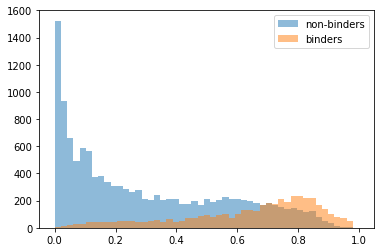

In [35]:
non_binders = df_chothia_master[df_chothia_master["chothia_label"]==0]["Parapred"].tolist()
binders = df_chothia_master[df_chothia_master["chothia_label"]==1]["Parapred"].tolist()

bins = np.linspace(0, 1, 50)

plt.hist(non_binders, bins, alpha=0.5, label='non-binders')
plt.hist(binders, bins, alpha=0.5, label='binders')
plt.legend(loc='upper right')
plt.show()